# Evaluación del modelo utilizando validación cruzada

La validación cruzada (Cross-validation) es un método estadístico usado para evaluar el desempeño de un modelo en un conjunto de datos independiente. 
- Implica dividir los datos en múltiples pliegues (folds) o subconjuntos, utilizando uno de estos pliegues como un conjunto de validación y entrenando el modelo en los pliegues restantes. 
- Este proceso se repite varias veces cada vez utilizando un pliegue diferente como conjunto de validación. 
- Finalmente, los resultados de cada paso de validación se promedian para producir una estimación más sólida del rendimiento del modelo.

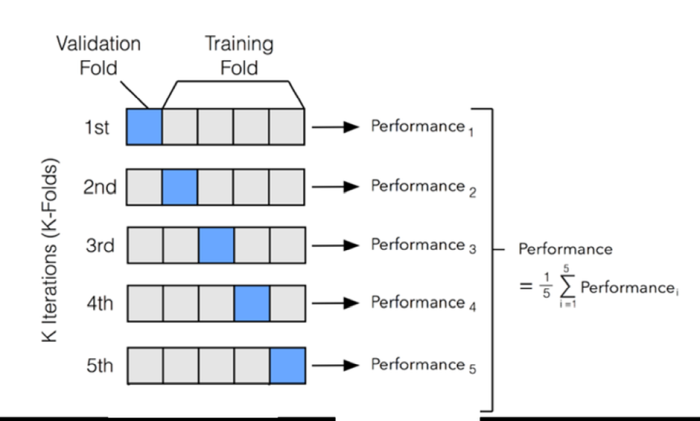

El objetivo principal de la validación cruzada es evitar el **sobreajuste**. 
- Al evaluar el modelo en múltiples conjuntos de validación, la validación cruzada proporciona una estimación más realista del rendimiento de generalización del modelo
- es decir, su capacidad para desempeñarse bien en datos nuevos, no vistos por el modelo.

Discutiremos los aspectos prácticos de evaluar el rendimiento de generalización de nuestro modelo a través de la validación cruzada en lugar de una sola división de entrenamiento-prueba.

## Preparación de datos

In [ ]:
import pandas as pd

adult_census = pd.read_csv("../../data/adult-census-numeric/train.csv")

In [ ]:
target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=target_name)

In [ ]:
numerical_columns = ["age", "capital-gain", "capital-loss", "hours-per-week"]
data_numeric = data[numerical_columns]

In [ ]:
# podemos crear un modelo utilizando la herramienta Make_Pipeline para encadenar el preprocesamiento y
# el estimador en cada iteración de la validación cruzada.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

# Validación cruzada
La función `cross_validate` permite hacer validación cruzada y debemos pasarle el modelo, los datos y el target.

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [ ]:
%%time
from sklearn.model_selection import cross_validate

model = make_pipeline(StandardScaler(), LogisticRegression())
cv_result = cross_validate(model, data_numeric, target, cv=5)
cv_result

La salida de cross_validate es un diccionario de Python, que por defecto contiene tres entradas:

- **fit_time**: el tiempo para entrenar el modelo en los datos de entrenamiento para cada pliegue.
- **score_time**: El tiempo para predecir con el modelo en los datos de prueba para cada pliegue.
- **test_score**: La puntuación predeterminada en los datos de prueba para cada pliegue.

In [ ]:
# Extraemos los puntajes calculados en el pliegue de prueba de cada ronda de validación cruzada del diccionario cv_result 
# y calculamos la precisión media y la variación de la precisión entre los pliegues.

scores = cv_result["test_score"]
print(
    "La precisión media de la validación cruzada es: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

## Estrategias de validación cruzada

Hay varias formas de realizar validación cruzada y, dependiendo del modelo, la disponibilidad de datos y el tipo de problema con el que estemos trabajando será un factor decisivo sobre qué técnica funcionará mejor.

Algunas de las técnicas más importantes son las siguientes:
- Holdout Cross-Validation
- Stratified K-Fold CV
- Leave P Out CV
- Monte Carlo Cross Validation/Shuffle Split
- Time Series CV
- K Fold Cross-Validation

*Ver anexo: Técnicas Validación Cruzada*

## Estabilidad de las estimaciones de validación cruzada
La **validación cruzada** permite estimar la **robustez de un modelo predictivo** repitiendo el procedimiento de división. Dará varios errores de entrenamiento y prueba y, por lo tanto, alguna estimación de la variabilidad del rendimiento de generalización del modelo.

Existen diferentes estrategias de validación cruzada, por ahora nos vamos a centrar en una llamada **“shuffle-split”**. En cada iteración de esta estrategia:
- mezclar aleatoriamente el orden de las muestras de una copia del conjunto de datos completo;
- dividir el conjunto de datos barajados en un tren y un conjunto de prueba;
- entrenar un nuevo modelo en el juego de trenes;
- evaluar el error de prueba en el equipo de prueba.

Repetimos este procedimiento n_splits veces. Hay que tener en cuenta que el coste computacional aumenta con n_splits.

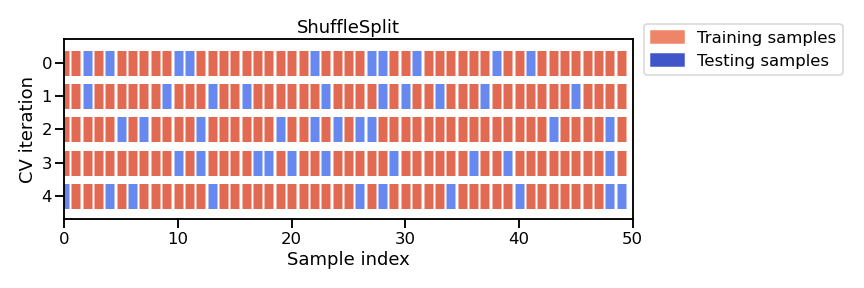

En este caso estableceremos n_splits=40, lo que significa que entrenaremos 40 modelos en total y todos serán descartados: solo registramos su **desempeño de generalización en cada variante del conjunto de prueba**.

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [ ]:
# Con un DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [ ]:
# Los resultados cv_results se almacenan en un diccionario Python.
# Lo convertiremos en un marco de datos de pandas para facilitar la visualización y manipulación.

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

In [ ]:
# revertimos los negativos
cv_results["test_error"] = -cv_results["test_score"]

# verificamos los resultados
cv_results.head(10)

In [9]:
len(cv_results)

40

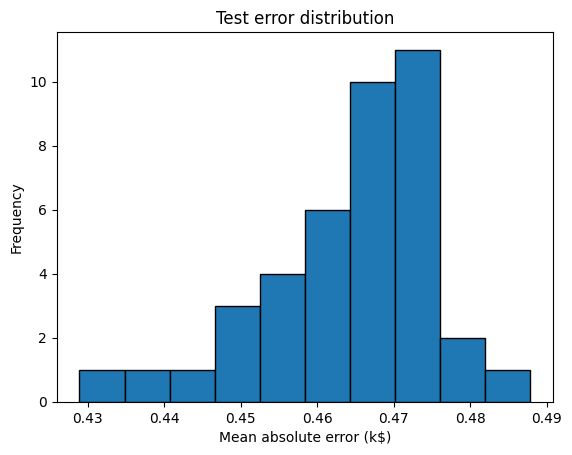

In [10]:
# Obtenemos 40 entradas en nuestro marco de datos resultante porque realizamos 40 divisiones.
# Por lo tanto, podemos mostrar la distribución del error de prueba y así tener una estimación de su variabilidad.

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [11]:
print(f"La media del cross-validated testing error es: "
      f"{cv_results['test_error'].mean():.2f}")

La media del cross-validated testing error es: 0.46


In [12]:
print(f"La desviación estandar del testing error es: "
      f"{cv_results['test_error'].std():.2f}")

La desviación estandar del testing error es: 0.01


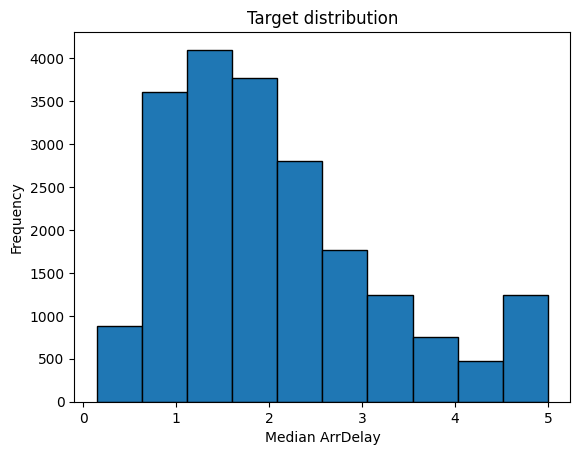

In [13]:
# Tracemos la distribución de la variable target

target.plot.hist(edgecolor="black")
plt.xlabel("Median ArrDelay")
_ = plt.title("Target distribution")

In [14]:
print(f"La desviación estándar del target es: {target.std():.2f}")

La desviación estándar del target es: 1.15


In [15]:
# En el caso de que solo esté interesado en el score de la prueba,
# scikit-learn proporciona la función cross_val_score.
# Es idéntico a llamar a la función cross_validate y seleccionar solo test_score.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.25280448, 0.38292026, 0.45167324, 0.22590099, 0.40581787])